In [43]:
import os, dendropy
import pandas as pd
import numpy as np
from scipy.stats import gmean, linregress, fisher_exact
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree
from itertools import combinations
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from treeplot import *
from Bio import Phylo
from skbio.stats.distance import mantel
plt.style.use('paper_style.mplstyle')

colors = {
    'dred':    '#c54e52', 'lred':    '#f8b1bb',
    'dblue':   '#3c5488', 'lblue':   '#bfd6ef',
    'dgreen':  '#00a087', 'lgreen':  '#c0e6ea',
    'dpink':   '#d78bbb', 'lpink':   '#f9d5e5',
    'dyellow': '#ccb974', 'lyellow': '#fff0c1',
    'gray': '#c0c0c0'}

# Identify high expression diversity genes

In [44]:
# load gene table
gene_table = pd.read_csv(
    'datasets/gt_mtb_h37rv.csv', index_col=0)

# load expression data
exp_data_path = 'rnaseq/normalized_isolate_expression.csv'
exp_df = pd.read_csv(
    exp_data_path,
    header=[0, 1, 2], index_col=0)

# load lineage data
lineage_data_path = f'datasets/lineage_assignments.csv'
lineage_df = pd.read_csv(
    lineage_data_path,
    index_col=0).astype('str')  # enforce string

In [45]:
expression_threshold = 3

# identify genes meeting expression threshold
mean_expression = exp_df.T.groupby('strain').mean().mean()
pass_exp_threshold = mean_expression >= expression_threshold

# calculate global relative variation
global_replicate_std = exp_df.T.groupby('strain').std().mean()
global_strain_std = exp_df.T.groupby('strain').mean().std()
global_rel_var = (
    global_strain_std / global_replicate_std)

# identify thresholds for variation
rel_threshold = np.percentile(global_rel_var[pass_exp_threshold], 95)
abs_threshold = np.percentile(global_strain_std[pass_exp_threshold], 50)

# identify high variation gene set on global strains
global_high_variation = pd.Series(index=mean_expression.index, data=np.all([
    pass_exp_threshold,
    global_rel_var >= rel_threshold,
    global_strain_std >= abs_threshold], axis=0))

# calculate relative variation for each lineage separately
target_lineage = '1'
lineage_mask = np.isin(
    exp_df.columns.get_level_values('strain'),
    lineage_df.index[lineage_df.loc[:, 'lineage'] == target_lineage])
L1_replicate_std = exp_df.loc[:, lineage_mask].T.groupby('strain').std().mean()
L1_strain_std = exp_df.loc[:, lineage_mask].T.groupby('strain').mean().std()
L1_rel_var = (
    L1_strain_std / L1_replicate_std)
L1_high_variation = pd.Series(index=mean_expression.index, data=np.all([
    pass_exp_threshold,
    L1_rel_var >= rel_threshold,
    L1_strain_std >= abs_threshold], axis=0))

target_lineage = '2'
lineage_mask = np.isin(
    exp_df.columns.get_level_values('strain'),
    lineage_df.index[lineage_df.loc[:, 'lineage'] == target_lineage])
L2_replicate_std = exp_df.loc[:, lineage_mask].T.groupby('strain').std().mean()
L2_strain_std = exp_df.loc[:, lineage_mask].T.groupby('strain').mean().std()
L2_rel_var = (
    L2_strain_std / L2_replicate_std)
L2_high_variation = pd.Series(index=mean_expression.index, data=np.all([
    pass_exp_threshold,
    L2_rel_var >= rel_threshold,
    L2_strain_std >= abs_threshold], axis=0))

target_lineage = '4'
lineage_mask = np.isin(
    exp_df.columns.get_level_values('strain'),
    lineage_df.index[lineage_df.loc[:, 'lineage'] == target_lineage])
L4_replicate_std = exp_df.loc[:, lineage_mask].T.groupby('strain').std().mean()
L4_strain_std = exp_df.loc[:, lineage_mask].T.groupby('strain').mean().std()
L4_rel_var = (
    L4_strain_std / L4_replicate_std)
L4_high_variation = pd.Series(index=mean_expression.index, data=np.all([
    pass_exp_threshold,
    L4_rel_var >= rel_threshold,
    L4_strain_std >= abs_threshold], axis=0))

# pass high variation in any of the above
any_high_variation = pd.Series(index=mean_expression.index, data=np.any([
    global_high_variation, L1_high_variation, L2_high_variation, L4_high_variation], axis=0))

# prepare dataframe merging lineage data
df_data = [
    pass_exp_threshold,
    global_strain_std, global_replicate_std, global_rel_var, global_high_variation,
    L1_strain_std, L1_replicate_std, L1_rel_var, L1_high_variation,
    L2_strain_std, L2_replicate_std, L2_rel_var, L2_high_variation,
    L4_strain_std, L4_replicate_std, L4_rel_var, L4_high_variation,
    any_high_variation]

df_columns = [
    'pass_exp_threshold',
    'global_strain_std', 'global_replicate_std', 'global_rel_var', 'global_high_var',
    'L1_strain_std', 'L1_replicate_std', 'L1_rel_var', 'L1_high_var',
    'L2_strain_std', 'L2_replicate_std', 'L2_rel_var', 'L2_high_var',
    'L4_strain_std', 'L4_replicate_std', 'L4_rel_var', 'L4_high_var',
    'any_high_var']

rel_var_df = pd.concat(
    df_data, axis=1)
rel_var_df.columns = df_columns

rel_var_df.to_csv('outputs/tables/TableS2_expression_diversity.csv')

In [46]:
any_high_variation.sum()

np.int64(151)

# Relative variation histogram

In [2]:
# load in diversity dataframe
diversity_df = pd.read_csv(
    'outputs/tables/TableS2_expression_diversity.csv', index_col=0)

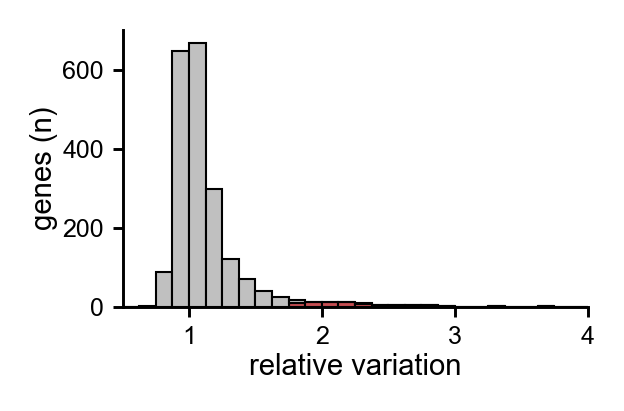

In [3]:
output_dir = 'outputs/figures'
output_name = '2A_high_diversity_outer.pdf'

fig, ax = plt.subplots(1, 1, figsize=(2, 1.2))
sns.histplot(
    ax=ax,
    data=diversity_df.loc[diversity_df.pass_exp_threshold],
    x='global_rel_var',
    hue='global_high_var',
    palette={False: colors['gray'], True: colors['dred']},
    multiple='stack',
    binrange=(0.5, 4),
    alpha=1,
    binwidth=0.125,
    linewidth=0.5,
    legend=False)

sns.despine()
ax.set_xlim(0.5, 4)
# ax.set_ylim(0, 100)
ax.set_ylabel('genes (n)')
ax.set_xlabel('relative variation')

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

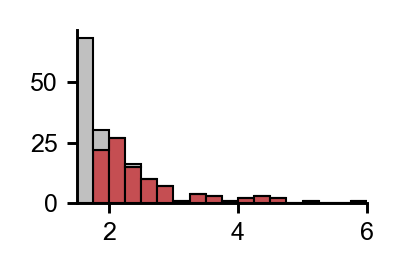

In [4]:
output_dir = 'outputs/figures'
output_name = '2A_high_diversity_inset.pdf'

fig, ax = plt.subplots(1, 1, figsize=(1.25, 0.75))

sns.histplot(
    ax=ax,
    data=diversity_df.loc[diversity_df.pass_exp_threshold],
    x='global_rel_var',
    hue='global_high_var',
    palette={False: colors['gray'], True: colors['dred']},
    multiple='stack',
    binrange=(1.5, 6),
    alpha=1,
    binwidth=0.25,
    linewidth=0.5,
    legend=False)

sns.despine()
ax.set_xlim(1.5, 6)
ax.set_xticks([2,  4, 6])
ax.set_ylabel('')
ax.set_xlabel('')

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

# PCAs and high diversity heatmaps

In [41]:
# load in diversity dataframe
diversity_df = pd.read_csv(
    'outputs/tables/TableS2_expression_diversity.csv', index_col=0)

# load lineage data
lineage_data_path = f'datasets/lineage_assignments.csv'
lineage_df = pd.read_csv(
    lineage_data_path,
    index_col=0).astype('str')  # enforce string

# load expression data
exp_data_path = 'rnaseq/normalized_isolate_expression.csv'
exp_df = pd.read_csv(
    exp_data_path,
    header=[0, 1, 2], index_col=0)
# get relative expression by strain
mean_exp = exp_df.T.groupby('strain').mean().mean()
rel_exp = exp_df - mean_exp.values.reshape(-1, 1)
rel_exp_by_strain = rel_exp.T.groupby('strain').mean()

## Expression heatmap

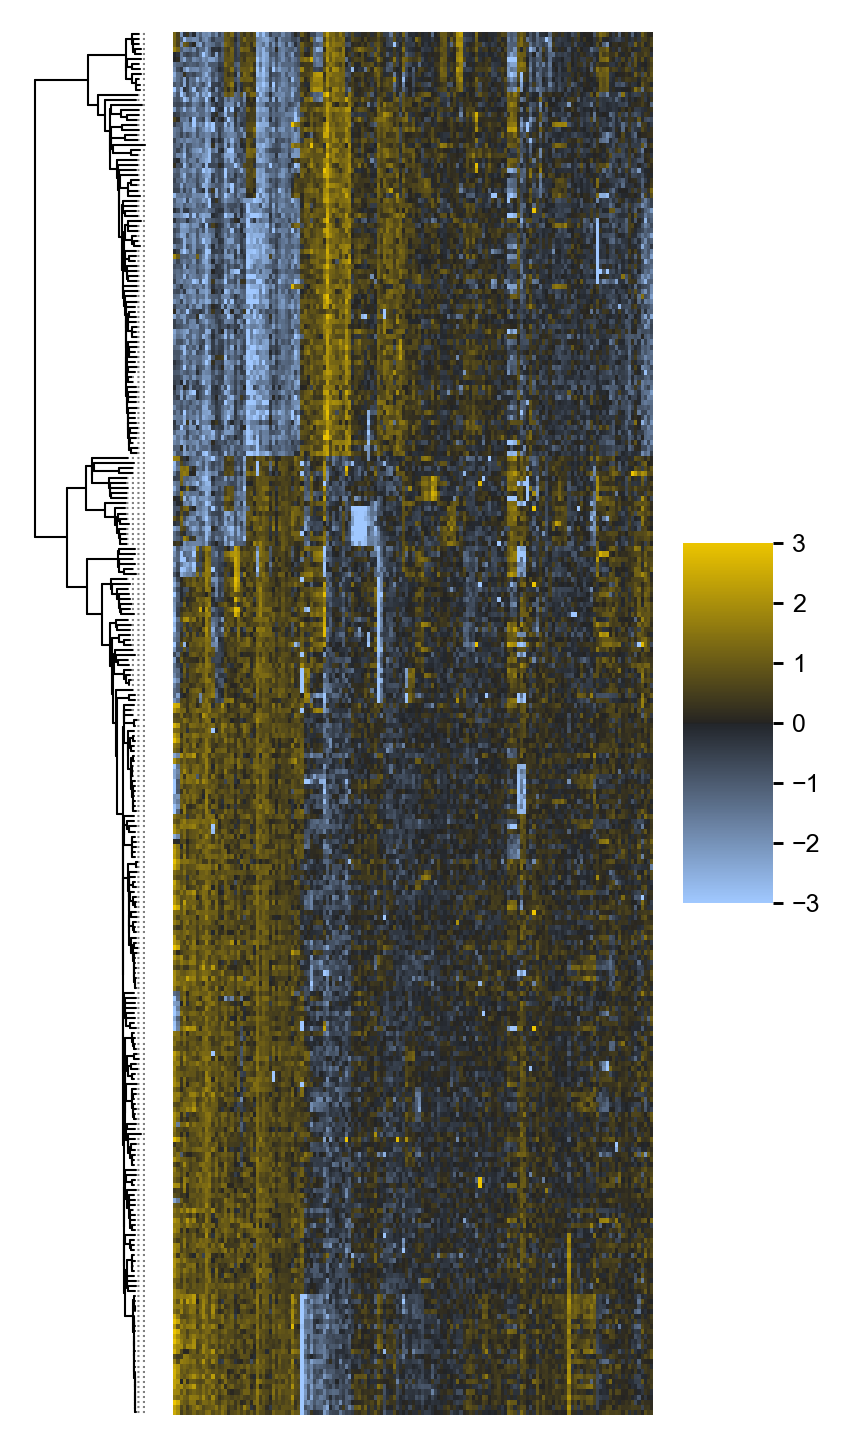

In [42]:
output_dir = 'outputs/figures'
output_name = '2B_gene_expression.pdf'
tree_path = 'datasets/trees/cohort_trees/rnaseq_strains.iq_snp_gtr_cons.rooted.contree.nwk'

tree = Phylo.read(tree_path, 'newick')

# cluster the data
cluster_data = rel_exp_by_strain.loc[:, diversity_df.any_high_var]
cluster_order = [
    int(i) for i in dendrogram(linkage(cluster_data.T, 'ward'), no_plot=True)['ivl']]

# load in the phylogenetic tree
tree_plot = TreePlot(
    phylo_obj=tree,
    root_name='canettii')

tree_plot.plotTree(
    figsize=(0.5, 6),
    tree_context={'lines.linewidth': 0.5}
    )

colormap = sns.diverging_palette(
    250, 70, s=120, l=80, as_cmap=True, center='dark')
ax = tree_plot.addHeatmap(
    width=4, input_data=cluster_data.iloc[:, cluster_order],
    vmin=-3, vmax=3,
    cmap=colormap, cbar_kws={'aspect': 4, 'shrink': .5}, rasterized=True)
ax.set_ylabel('')
ax.set_xticks([])
plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

## First 3 Components (main text)

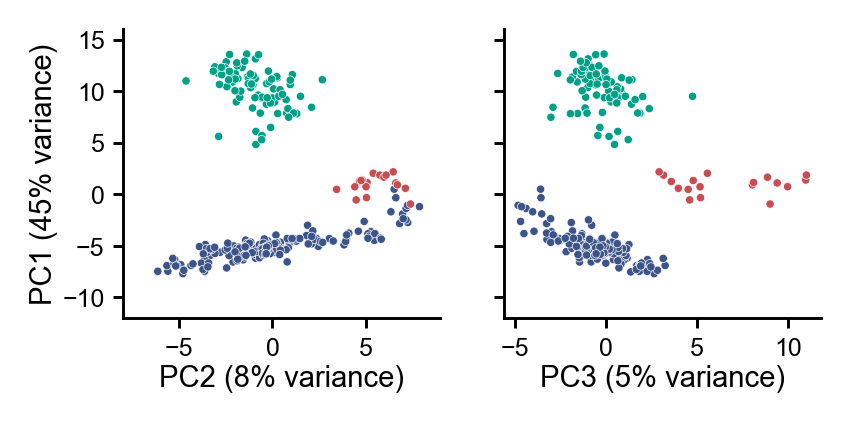

In [7]:
output_dir = 'outputs/figures'
output_name = '2C_PCA_main_text.pdf'

pca_input = rel_exp_by_strain.loc[
    :, diversity_df.any_high_var]
n_comp = 25

# fit a model
model = PCA(n_components=n_comp)
model.fit(pca_input)
transform = model.transform(pca_input)

# generate eigenvector df
comp = model.components_.T
comp_df = pd.DataFrame(
    data=comp,
    columns=[f'PC{n + 1}' for n in range(n_comp)],
    index=pca_input.columns)

# generate a PC dataframe
pca_df = pd.DataFrame(
    data=transform,
    index=pca_input.index,
    columns=[f'PC{n + 1}' for n in range(n_comp)])
# invert (arbitrary signs on PCA)
pca_df = pca_df * -1
#
pca_df.loc[:, 'lineage'] = lineage_df.loc[pca_df.index, 'lineage']

fig, axes = plt.subplots(1, 2, figsize=(3, 1.25), sharey=True)

# PC1 x PC2
sns.scatterplot(
    ax=axes[0],
    data=pca_df,
    x='PC2',
    y='PC1',
    hue='lineage',
    palette={'1': colors['dgreen'], '2': colors['dblue'], '4': colors['dred']},
    s=4,
    legend=False)

# PC1 x PC3
sns.scatterplot(
    ax=axes[1],
    data=pca_df,
    x='PC3',
    y='PC1',
    hue='lineage',
    palette={'1': colors['dgreen'], '2': colors['dblue'], '4': colors['dred']},
    s=4,
    legend=False)
# axes.set_yticks([-4, 0, 4, 8])2
axes[0].set_yticks([-10, -5, 0, 5, 10, 15])

axes[0].set_ylabel(f'PC1 ({int(np.round(100*model.explained_variance_ratio_[0], 0))}% variance)')
axes[0].set_xlabel(f'PC2 ({int(np.round(100*model.explained_variance_ratio_[1], 0))}% variance)')
axes[1].set_xlabel(f'PC3 ({int(np.round(100*model.explained_variance_ratio_[2], 0))}% variance)')
axes[0].set_ylim(-12, 16)
axes[0].set_xlim(-8, 9)

# f2d_ylim = ax.get_ylim()

sns.despine()
plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=400)

## Second PC heatmap (main text)

In [8]:
pc2_l2_values = pca_df.loc[:, ['PC2']]  # get PC2 values
pc2_l2_values.loc[pca_df.lineage != '2'] = np.nan  # mask non-L2 values

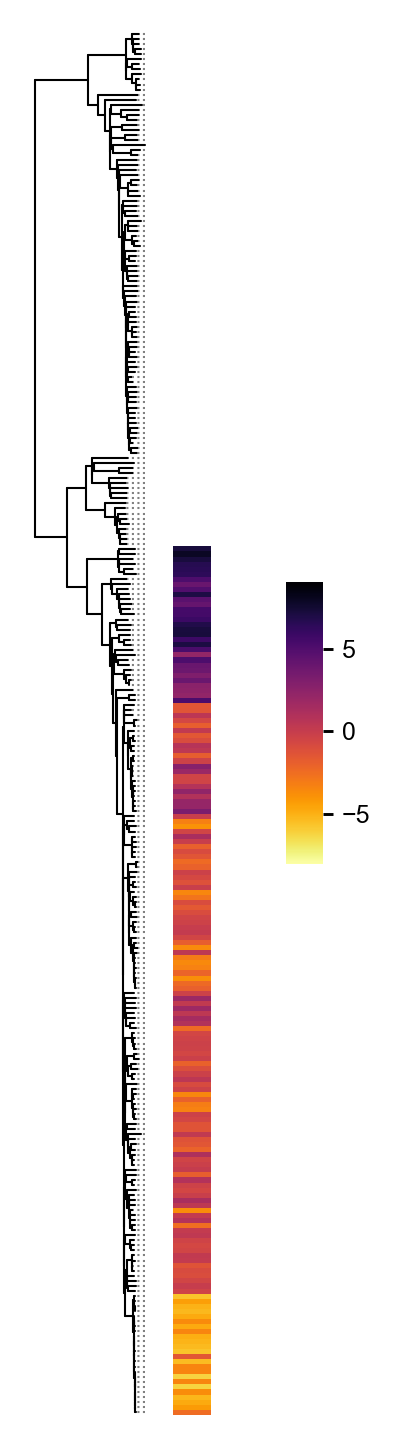

In [9]:
output_dir = 'outputs/figures'
output_name = '2C_PCA_heatmap.pdf'
tree_path = 'datasets/trees/cohort_trees/rnaseq_strains.iq_snp_gtr_cons.rooted.contree.nwk'

tree = Phylo.read(tree_path, 'newick')

# load in the phylogenetic tree
tree_plot = TreePlot(
    phylo_obj=tree,
    root_name='canettii')

tree_plot.plotTree(
    figsize=(0.5, 6),
    tree_context={'lines.linewidth': 0.5}
    )

colormap = sns.diverging_palette(
    250, 70, s=120, l=80, as_cmap=True, center='dark')
ax = tree_plot.addHeatmap(
    width=1, input_data=pc2_l2_values,
    vmin=-8, vmax=9,
    cmap='inferno_r', cbar_kws={'fraction':.25, 'pad': .5, 'aspect': 7.5, 'shrink': 10}, rasterized=True)
ax.set_ylabel('')
ax.set_xticks([])
plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

## 5 PCAs (supplemental)

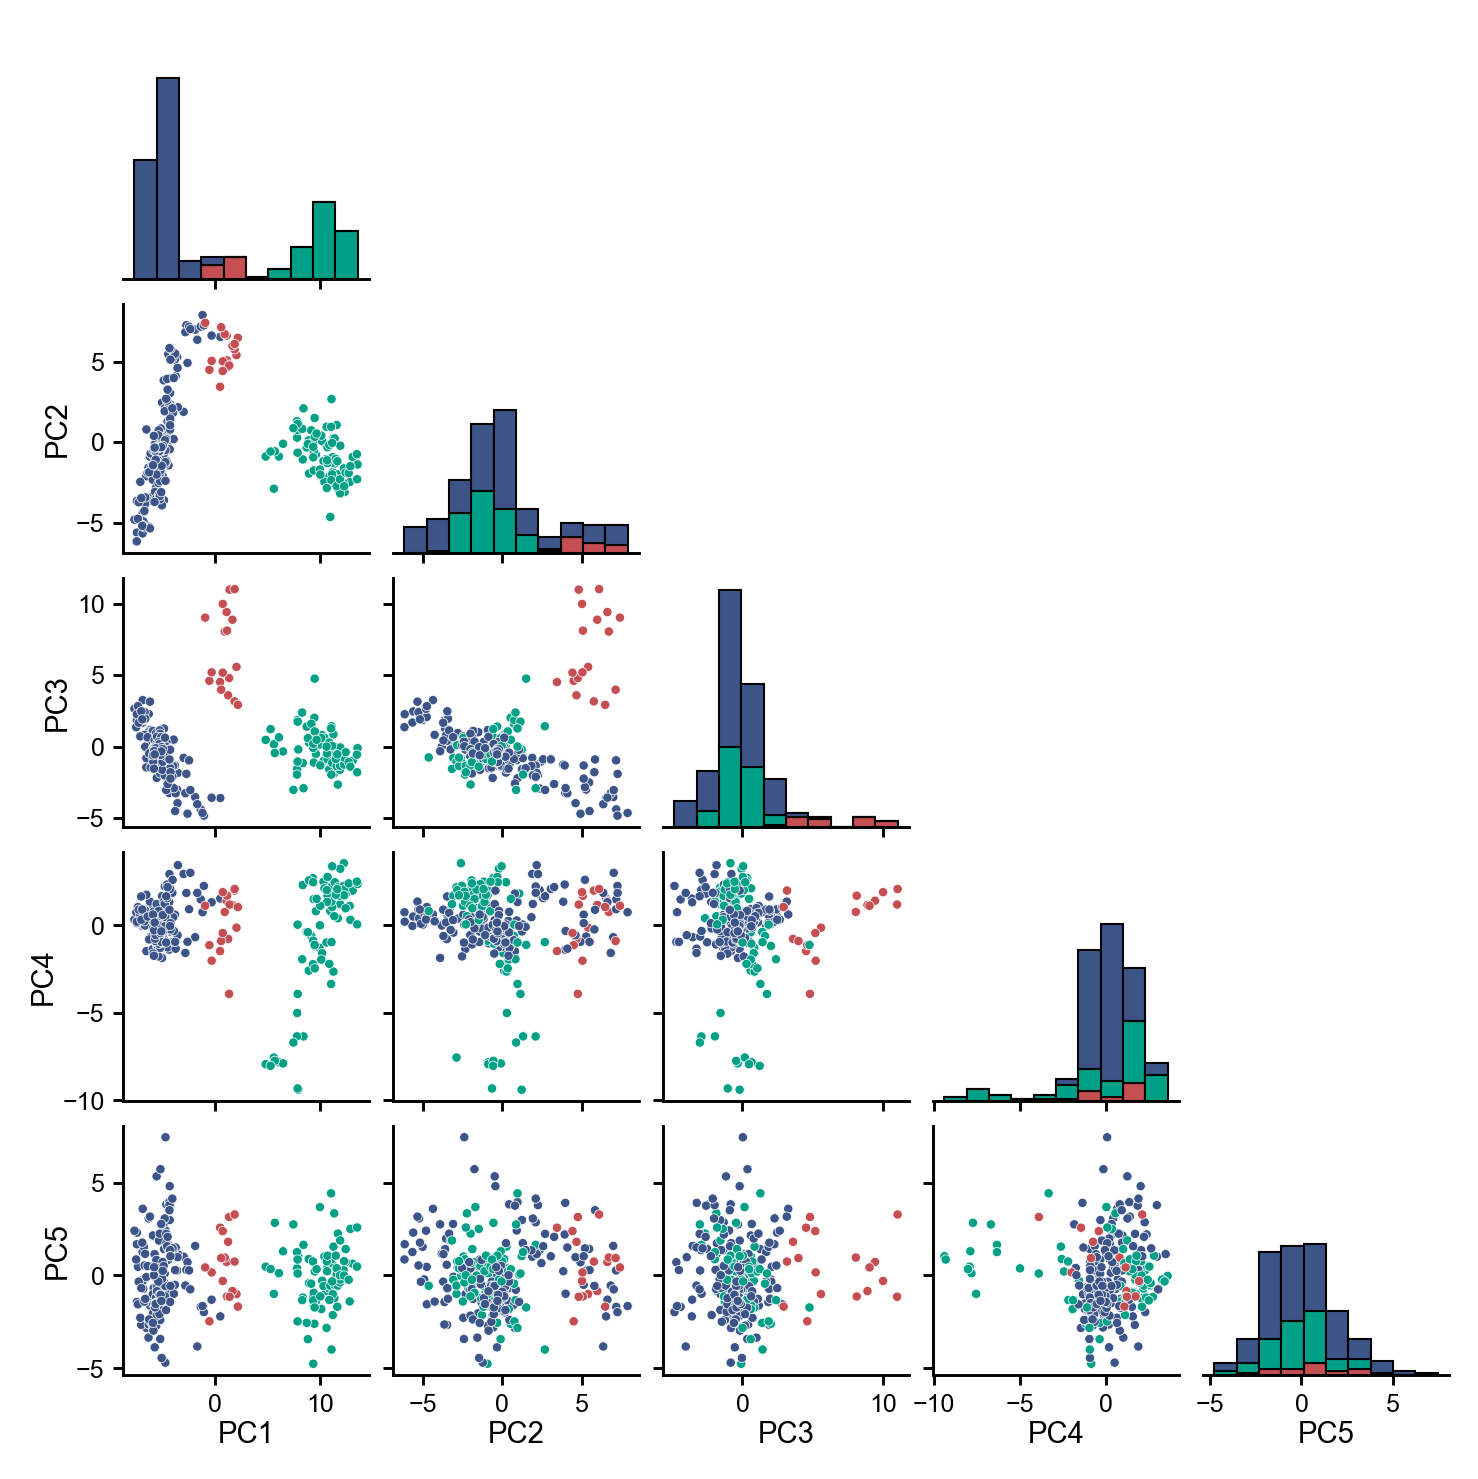

In [10]:
output_dir = 'outputs/figures'
output_name = 'S2A_PCA_supplementary.pdf'

pca_input = rel_exp_by_strain.loc[
    :, diversity_df.any_high_var]
n_comp = 5

# fit a model
model = PCA(n_components=n_comp)
model.fit(pca_input)
transform = model.transform(pca_input)

# generate eigenvector df
comp = model.components_.T
comp_df = pd.DataFrame(
    data=comp,
    columns=[f'PC{n + 1}' for n in range(n_comp)],
    index=pca_input.columns)

# generate a PC dataframe
pca_df = pd.DataFrame(
    data=transform,
    index=pca_input.index,
    columns=[f'PC{n + 1}' for n in range(n_comp)])
# invert (arbitrary signs on PCA)
pca_df = pca_df * -1

pca_df.loc[:, 'lineage'] = lineage_df.loc[pca_df.index, 'lineage']




g = sns.PairGrid(
    pca_df, corner=True, height=1, hue='lineage',
    palette={'1': colors['dgreen'], '2': colors['dblue'], '4': colors['dred']},)
g.map_lower(sns.scatterplot, s=5, rasterized=True)
g.map_diag(sns.histplot, bins=10, multiple='stack', linewidth=0.5, alpha=1)
plt.subplots_adjust(hspace=0.1, wspace=0.1)

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=400)

## PC heatmaps (supplemental)

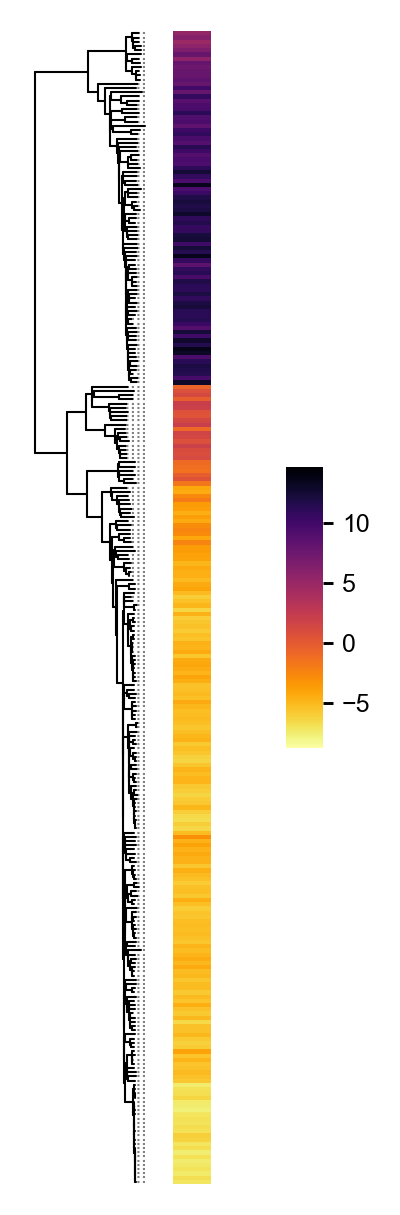

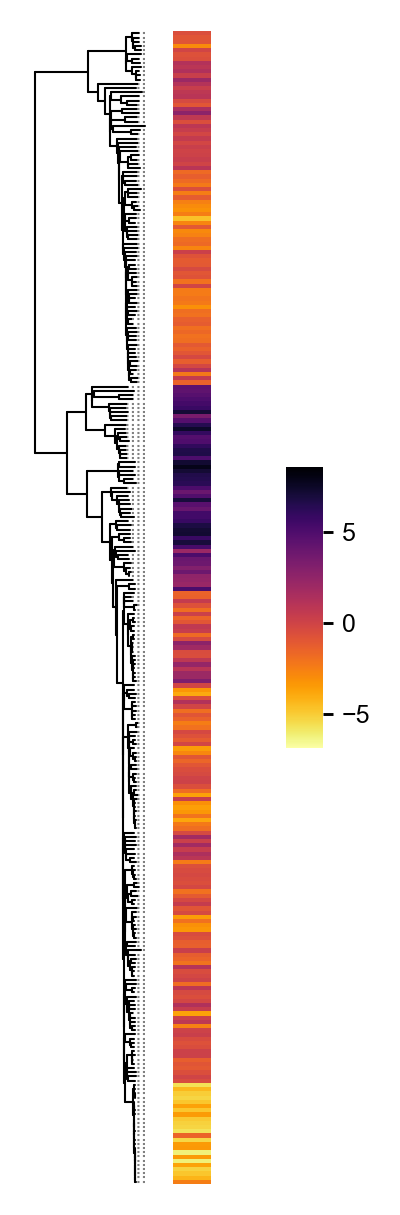

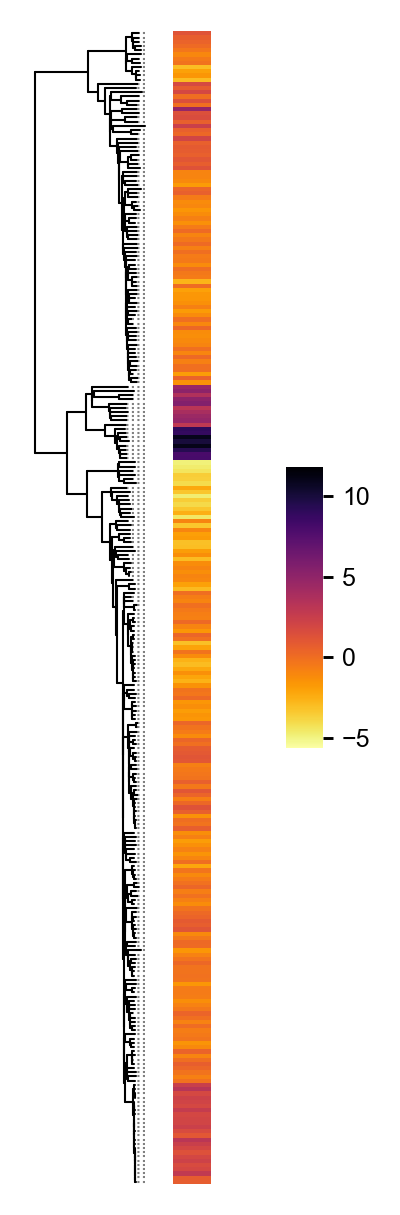

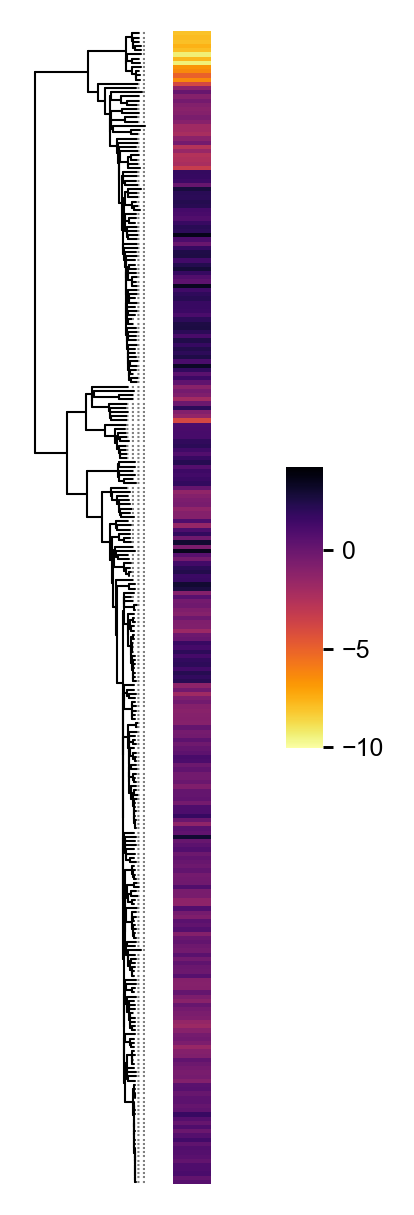

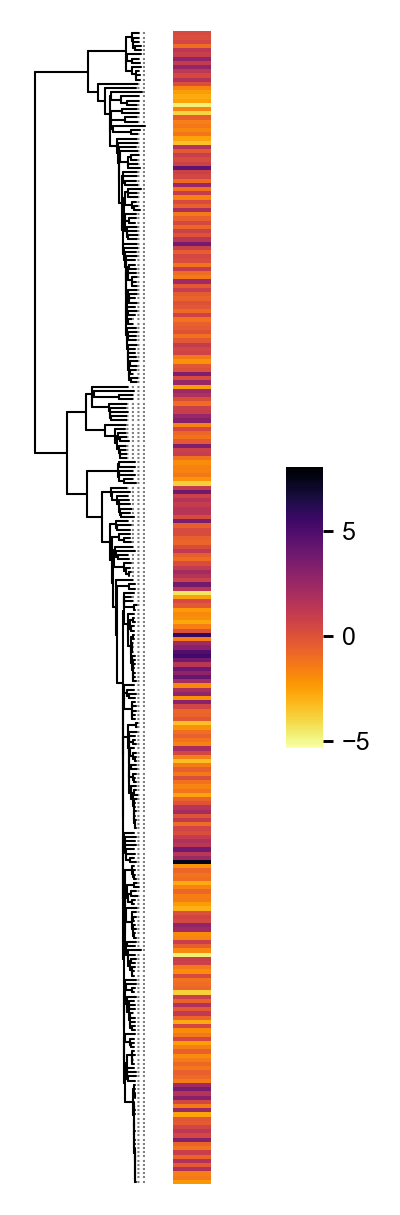

In [11]:
output_dir = 'outputs/figures'
tree_path = 'datasets/trees/cohort_trees/rnaseq_strains.iq_snp_gtr_cons.rooted.contree.nwk'

tree = Phylo.read(tree_path, 'newick')

for ax in g.axes[-1]:
    xlabel = ax.get_xlabel()
    pc_min, pc_max = ax.get_xlim()
    output_name = f'S2B_multi_PC_tree_{xlabel}.pdf'
    # load in the phylogenetic tree
    tree_plot = TreePlot(
        phylo_obj=tree,
        root_name='canettii')
    
    tree_plot.plotTree(
        figsize=(0.5, 5),
        tree_context={'lines.linewidth': 0.5})
    colormap = sns.diverging_palette(
        250, 70, s=120, l=80, as_cmap=True, center='dark')
    ax = tree_plot.addHeatmap(
        width=1, input_data=pca_df.loc[:, [xlabel]],
        vmin=pc_min, vmax=pc_max,
        cmap='inferno_r', cbar_kws={'fraction':.25, 'pad': .5, 'aspect': 7.5, 'shrink': 10}, rasterized=True)
    ax.set_ylabel('')
    ax.set_xticks([])
    plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

## Identify Peru Strains

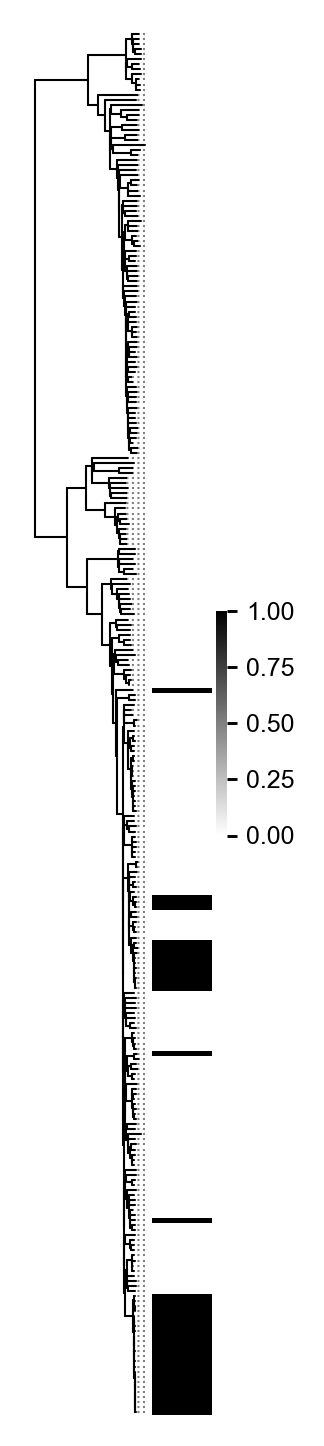

In [12]:
is_peru = pd.DataFrame(pd.Series(
    index=pca_df.index,
    data=['g2g' in s for s in pca_df.index],
    name='is_peru'))

output_name = '2B_is_peru.pdf'
output_dir = 'outputs/figures'
tree_path = 'datasets/trees/cohort_trees/rnaseq_strains.iq_snp_gtr_cons.rooted.contree.nwk'

tree = Phylo.read(tree_path, 'newick')

tree_plot.plotTree(
    figsize=(0.5, 6),
    tree_context={'lines.linewidth': 0.5})

colormap = sns.diverging_palette(
    250, 70, s=120, l=80, as_cmap=True, center='dark')
ax = tree_plot.addHeatmap(
    width=.5, input_data=is_peru,
    cmap='binary', rasterized=False)
ax.set_ylabel('')
ax.set_xticks([])
plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

# Quantitative comparison of phylogenetic and phenotypic trees

In [2]:
# load in diversity dataframe
diversity_df = pd.read_csv(
    'outputs/tables/TableS2_expression_diversity.csv', index_col=0)

# load lineage data
lineage_data_path = f'datasets/lineage_assignments.csv'
lineage_df = pd.read_csv(
    lineage_data_path,
    index_col=0).astype('str')  # enforce string

# load expression data
exp_data_path = 'rnaseq/normalized_isolate_expression.csv'
exp_df = pd.read_csv(
    exp_data_path,
    header=[0, 1, 2], index_col=0)
# get relative expression by strain
mean_exp = exp_df.T.groupby('strain').mean().mean()
rel_exp = exp_df - mean_exp.values.reshape(-1, 1)
rel_exp_by_strain = rel_exp.T.groupby('strain').mean()

## All Strains

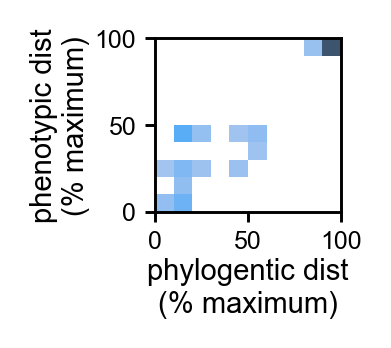

regression: slope=0.96 intercept=7.03 rsq=0.89


LinregressResult(slope=np.float64(0.9587255282873663), intercept=np.float64(7.032040030653441), rvalue=np.float64(0.943216805188817), pvalue=np.float64(0.0), stderr=np.float64(0.0017459158490681426), intercept_stderr=np.float64(0.11298711015768376))

In [7]:
output_dir = 'outputs/figures'
output_name = '2D_phylopheno_comparison_all.pdf'
target_strains = lineage_df.index

tree_path = 'datasets/trees/cohort_trees/rnaseq_strains.iq_snp_gtr_cons.rooted.contree.nwk'
distances_tmp = 'tmp/distance_table.csv'


## get phylogenetic distances
phylogenetic_tree = dendropy.Tree.get(
        path=tree_path,
        schema='newick',
        preserve_underscores=True)

# generate a table and normalize
phylogenetic_dm = phylogenetic_tree.phylogenetic_distance_matrix()
phylogenetic_dm.as_data_table().write_csv(distances_tmp)
phylogenetic_distances = pd.read_csv(
    distances_tmp, index_col=0)
# subset & reorder strains
phylogenetic_distances = phylogenetic_distances.loc[
    target_strains, target_strains]
os.remove(distances_tmp)
phylogenetic_distances = (  # normalize
    phylogenetic_distances / phylogenetic_distances.max().max()) * 100


## conduct phenotypic clustering
# choose data for clustering
cluster_data = rel_exp_by_strain.loc[target_strains, diversity_df.any_high_var]

# convert to a newick tree and load into dendropy
phenotypic_tree = to_tree(
    linkage(cluster_data, 'ward'), False)
phenotypic_tree = dendropy.Tree.get_from_string(
    get_newick(phenotypic_tree, phenotypic_tree.dist, cluster_data.index),
    schema='newick', preserve_underscores=True)

# generate a table and normalize
phenotypic_dm = phenotypic_tree.phylogenetic_distance_matrix()
phenotypic_dm.as_data_table().write_csv(distances_tmp)
phenotypic_distances = pd.read_csv(
    distances_tmp, index_col=0)
os.remove(distances_tmp)
# subset & reorder strains
phenotypic_distances = phenotypic_distances.loc[
    target_strains, target_strains]
phenotypic_distances = (  # normalize
    phenotypic_distances / phenotypic_distances.max().max()) * 100


## generate the plot
# get pairwise comparisons
pair_index = list(
    combinations(phenotypic_distances.index, 2))

distance_plot_df = pd.concat([
    phylogenetic_distances.stack().loc[pair_index],
    phenotypic_distances.stack().loc[pair_index]], axis=1)
distance_plot_df.columns = ['phylo_d', 'pheno_d']

# plot the data
fig, ax = plt.subplots(1, 1, figsize=(.8, 0.75))

sns.histplot(
    ax=ax,
    data=distance_plot_df,
    x='phylo_d',
    y='pheno_d',
    pthresh=0.05, pmax=1,
    binwidth=(10, 10),
    binrange=((0, 100), (0, 100)))

regress_result = linregress(
    distance_plot_df.phylo_d, distance_plot_df.pheno_d)

ax.set_ylim(0, 100)
ax.set_xlim(0, 100)

ax.set_xlabel('phylogentic dist\n(% maximum)')
ax.set_ylabel('phenotypic dist\n(% maximum)')
plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f'regression: slope={regress_result.slope:.2f} intercept={regress_result.intercept:.2f} rsq={regress_result.rvalue**2:.2f}')
regress_result

In [10]:
# check that arrays match
if ~np.all(phenotypic_distances.index == phylogenetic_distances.index):
    raise ValueError('indexes do not match')

if ~np.all(phenotypic_distances.columns == phylogenetic_distances.columns):
    raise ValueError('indexes do not match')

mantel(phenotypic_distances, phylogenetic_distances, permutations=999999)

(np.float64(0.9432168051888161), np.float64(1e-06), 274)

## Lineage 1

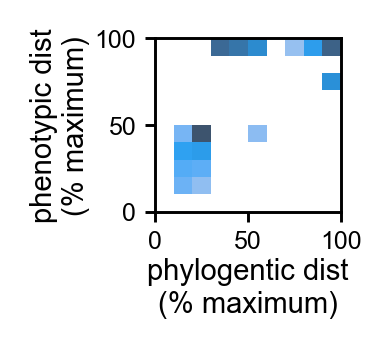

regression: slope=0.75 intercept=32.78 rsq=0.41


LinregressResult(slope=np.float64(0.7490775556361093), intercept=np.float64(32.777269962718314), rvalue=np.float64(0.6410145709963447), pvalue=np.float64(0.0), stderr=np.float64(0.015195480552697592), intercept_stderr=np.float64(0.8418941672465521))

In [11]:
output_dir = 'outputs/figures'
output_name = '2D_phylopheno_comparison_L1.pdf'
target_strains = lineage_df.index[lineage_df.lineage == '1']

tree_path = 'datasets/trees/cohort_trees/rnaseq_strains.iq_snp_gtr_cons.rooted.contree.nwk'
distances_tmp = 'tmp/distance_table.csv'


## get phylogenetic distances
phylogenetic_tree = dendropy.Tree.get(
        path=tree_path,
        schema='newick',
        preserve_underscores=True)

# generate a table and normalize
phylogenetic_dm = phylogenetic_tree.phylogenetic_distance_matrix()
phylogenetic_dm.as_data_table().write_csv(distances_tmp)
phylogenetic_distances = pd.read_csv(
    distances_tmp, index_col=0)
# subset & reorder strains
phylogenetic_distances = phylogenetic_distances.loc[
    target_strains, target_strains]
os.remove(distances_tmp)
phylogenetic_distances = (  # normalize
    phylogenetic_distances / phylogenetic_distances.max().max()) * 100


## conduct phenotypic clustering
# choose data for clustering
cluster_data = rel_exp_by_strain.loc[target_strains, diversity_df.any_high_var]

# convert to a newick tree and load into dendropy
phenotypic_tree = to_tree(
    linkage(cluster_data, 'ward'), False)
phenotypic_tree = dendropy.Tree.get_from_string(
    get_newick(phenotypic_tree, phenotypic_tree.dist, cluster_data.index),
    schema='newick', preserve_underscores=True)

# generate a table and normalize
phenotypic_dm = phenotypic_tree.phylogenetic_distance_matrix()
phenotypic_dm.as_data_table().write_csv(distances_tmp)
phenotypic_distances = pd.read_csv(
    distances_tmp, index_col=0)
os.remove(distances_tmp)
# subset & reorder strains
phenotypic_distances = phenotypic_distances.loc[
    target_strains, target_strains]
phenotypic_distances = (  # normalize
    phenotypic_distances / phenotypic_distances.max().max()) * 100


## generate the plot
# get pairwise comparisons
pair_index = list(
    combinations(phenotypic_distances.index, 2))

distance_plot_df = pd.concat([
    phylogenetic_distances.stack().loc[pair_index],
    phenotypic_distances.stack().loc[pair_index]], axis=1)
distance_plot_df.columns = ['phylo_d', 'pheno_d']

# plot the data
fig, ax = plt.subplots(1, 1, figsize=(.8, 0.75))

sns.histplot(
    ax=ax,
    data=distance_plot_df,
    x='phylo_d',
    y='pheno_d',
    pthresh=0.05, pmax=1,
    binwidth=(10, 10),
    binrange=((0, 100), (0, 100)))

regress_result = linregress(
    distance_plot_df.phylo_d, distance_plot_df.pheno_d)

ax.set_ylim(0, 100)
ax.set_xlim(0, 100)

ax.set_xlabel('phylogentic dist\n(% maximum)')
ax.set_ylabel('phenotypic dist\n(% maximum)')
plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f'regression: slope={regress_result.slope:.2f} intercept={regress_result.intercept:.2f} rsq={regress_result.rvalue**2:.2f}')
regress_result

In [12]:
# check that arrays match
if ~np.all(phenotypic_distances.index == phylogenetic_distances.index):
    raise ValueError('indexes do not match')

if ~np.all(phenotypic_distances.columns == phylogenetic_distances.columns):
    raise ValueError('indexes do not match')

mantel(phenotypic_distances, phylogenetic_distances, permutations=999999)

(np.float64(0.6410145709963453), np.float64(1e-06), 84)

## Lineage 2

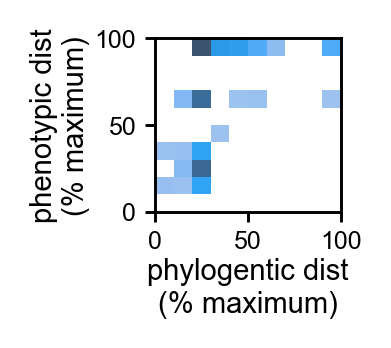

regression: slope=0.66 intercept=45.54 rsq=0.17


LinregressResult(slope=np.float64(0.663481807322682), intercept=np.float64(45.53727567493378), rvalue=np.float64(0.4123418869766886), pvalue=np.float64(0.0), stderr=np.float64(0.012088881092831653), intercept_stderr=np.float64(0.46142992742764705))

In [13]:
output_dir = 'outputs/figures'
output_name = '2D_phylopheno_comparison_L2.pdf'
target_strains = lineage_df.index[lineage_df.lineage == '2']

tree_path = 'datasets/trees/cohort_trees/rnaseq_strains.iq_snp_gtr_cons.rooted.contree.nwk'
distances_tmp = 'tmp/distance_table.csv'


## get phylogenetic distances
phylogenetic_tree = dendropy.Tree.get(
        path=tree_path,
        schema='newick',
        preserve_underscores=True)

# generate a table and normalize
phylogenetic_dm = phylogenetic_tree.phylogenetic_distance_matrix()
phylogenetic_dm.as_data_table().write_csv(distances_tmp)
phylogenetic_distances = pd.read_csv(
    distances_tmp, index_col=0)
# subset & reorder strains
phylogenetic_distances = phylogenetic_distances.loc[
    target_strains, target_strains]
os.remove(distances_tmp)
phylogenetic_distances = (  # normalize
    phylogenetic_distances / phylogenetic_distances.max().max()) * 100


## conduct phenotypic clustering
# choose data for clustering
cluster_data = rel_exp_by_strain.loc[target_strains, diversity_df.any_high_var]

# convert to a newick tree and load into dendropy
phenotypic_tree = to_tree(
    linkage(cluster_data, 'ward'), False)
phenotypic_tree = dendropy.Tree.get_from_string(
    get_newick(phenotypic_tree, phenotypic_tree.dist, cluster_data.index),
    schema='newick', preserve_underscores=True)

# generate a table and normalize
phenotypic_dm = phenotypic_tree.phylogenetic_distance_matrix()
phenotypic_dm.as_data_table().write_csv(distances_tmp)
phenotypic_distances = pd.read_csv(
    distances_tmp, index_col=0)
os.remove(distances_tmp)
# subset & reorder strains
phenotypic_distances = phenotypic_distances.loc[
    target_strains, target_strains]
phenotypic_distances = (  # normalize
    phenotypic_distances / phenotypic_distances.max().max()) * 100


## generate the plot
# get pairwise comparisons
pair_index = list(
    combinations(phenotypic_distances.index, 2))

distance_plot_df = pd.concat([
    phylogenetic_distances.stack().loc[pair_index],
    phenotypic_distances.stack().loc[pair_index]], axis=1)
distance_plot_df.columns = ['phylo_d', 'pheno_d']

# plot the data
fig, ax = plt.subplots(1, 1, figsize=(.8, 0.75))

sns.histplot(
    ax=ax,
    data=distance_plot_df,
    x='phylo_d',
    y='pheno_d',
    pthresh=0.05, pmax=1,
    binwidth=(10, 10),
    binrange=((0, 100), (0, 100)))

regress_result = linregress(
    distance_plot_df.phylo_d, distance_plot_df.pheno_d)

ax.set_ylim(0, 100)
ax.set_xlim(0, 100)

ax.set_xlabel('phylogentic dist\n(% maximum)')
ax.set_ylabel('phenotypic dist\n(% maximum)')
plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f'regression: slope={regress_result.slope:.2f} intercept={regress_result.intercept:.2f} rsq={regress_result.rvalue**2:.2f}')
regress_result

In [14]:
# check that arrays match
if ~np.all(phenotypic_distances.index == phylogenetic_distances.index):
    raise ValueError('indexes do not match')

if ~np.all(phenotypic_distances.columns == phylogenetic_distances.columns):
    raise ValueError('indexes do not match')

mantel(phenotypic_distances, phylogenetic_distances, permutations=999999)

(np.float64(0.4123418869766888), np.float64(1e-06), 172)

## Lineage 4

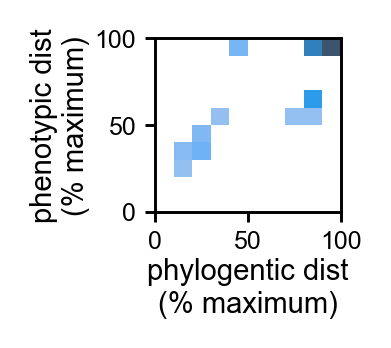

regression: slope=0.71 intercept=24.67 rsq=0.55


LinregressResult(slope=np.float64(0.7083967618135453), intercept=np.float64(24.668258693754133), rvalue=np.float64(0.7443926581704078), pvalue=np.float64(2.8418563199606217e-28), stderr=np.float64(0.051712412563634166), intercept_stderr=np.float64(3.9690117286396744))

In [15]:
output_dir = 'outputs/figures'
output_name = '2D_phylopheno_comparison_L4.pdf'
target_strains = lineage_df.index[lineage_df.lineage == '4']

tree_path = 'datasets/trees/cohort_trees/rnaseq_strains.iq_snp_gtr_cons.rooted.contree.nwk'
distances_tmp = 'tmp/distance_table.csv'


## get phylogenetic distances
phylogenetic_tree = dendropy.Tree.get(
        path=tree_path,
        schema='newick',
        preserve_underscores=True)

# generate a table and normalize
phylogenetic_dm = phylogenetic_tree.phylogenetic_distance_matrix()
phylogenetic_dm.as_data_table().write_csv(distances_tmp)
phylogenetic_distances = pd.read_csv(
    distances_tmp, index_col=0)
# subset & reorder strains
phylogenetic_distances = phylogenetic_distances.loc[
    target_strains, target_strains]
os.remove(distances_tmp)
phylogenetic_distances = (  # normalize
    phylogenetic_distances / phylogenetic_distances.max().max()) * 100


## conduct phenotypic clustering
# choose data for clustering
cluster_data = rel_exp_by_strain.loc[target_strains, diversity_df.any_high_var]

# convert to a newick tree and load into dendropy
phenotypic_tree = to_tree(
    linkage(cluster_data, 'ward'), False)
phenotypic_tree = dendropy.Tree.get_from_string(
    get_newick(phenotypic_tree, phenotypic_tree.dist, cluster_data.index),
    schema='newick', preserve_underscores=True)

# generate a table and normalize
phenotypic_dm = phenotypic_tree.phylogenetic_distance_matrix()
phenotypic_dm.as_data_table().write_csv(distances_tmp)
phenotypic_distances = pd.read_csv(
    distances_tmp, index_col=0)
os.remove(distances_tmp)
# subset & reorder strains
phenotypic_distances = phenotypic_distances.loc[
    target_strains, target_strains]
phenotypic_distances = (  # normalize
    phenotypic_distances / phenotypic_distances.max().max()) * 100


## generate the plot
# get pairwise comparisons
pair_index = list(
    combinations(phenotypic_distances.index, 2))

distance_plot_df = pd.concat([
    phylogenetic_distances.stack().loc[pair_index],
    phenotypic_distances.stack().loc[pair_index]], axis=1)
distance_plot_df.columns = ['phylo_d', 'pheno_d']

# plot the data
fig, ax = plt.subplots(1, 1, figsize=(.8, 0.75))

sns.histplot(
    ax=ax,
    data=distance_plot_df,
    x='phylo_d',
    y='pheno_d',
    pthresh=0.05, pmax=1,
    binwidth=(10, 10),
    binrange=((0, 100), (0, 100)))

regress_result = linregress(
    distance_plot_df.phylo_d, distance_plot_df.pheno_d)

ax.set_ylim(0, 100)
ax.set_xlim(0, 100)

ax.set_xlabel('phylogentic dist\n(% maximum)')
ax.set_ylabel('phenotypic dist\n(% maximum)')
plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f'regression: slope={regress_result.slope:.2f} intercept={regress_result.intercept:.2f} rsq={regress_result.rvalue**2:.2f}')
regress_result

In [16]:
# check that arrays match
if ~np.all(phenotypic_distances.index == phylogenetic_distances.index):
    raise ValueError('indexes do not match')

if ~np.all(phenotypic_distances.columns == phylogenetic_distances.columns):
    raise ValueError('indexes do not match')

mantel(phenotypic_distances, phylogenetic_distances, permutations=999999)

(np.float64(0.7443926581704087), np.float64(1e-06), 18)

# Expression diversity & gene categories

Load in and process datasets.

In [29]:
# load expression data
exp_data_path = 'rnaseq/normalized_isolate_expression.csv'
exp_df = pd.read_csv(
    exp_data_path,
    header=[0, 1, 2], index_col=0)
# get relative expression by strain
mean_exp = exp_df.T.groupby('strain').mean().mean()
rel_exp = exp_df - mean_exp.values.reshape(-1, 1)
rel_exp_by_strain = rel_exp.T.groupby('strain').mean()


## load in diversity dataframe
diversity_df = pd.read_csv(
    'outputs/tables/TableS2_expression_diversity.csv', index_col=0)

## mycobrowser
mycobrowser_df = pd.read_csv(
    'datasets/Mycobacterium_tuberculosis_H37Rv_txt_v5.txt',
    delimiter='\t', index_col='Locus')
mycobrowser_df = mycobrowser_df.loc[mycobrowser_df.Feature == 'CDS']


## in vitro essentiality
in_vitro_df = pd.read_csv(
    'datasets/dejesus_in_vitro_essential.csv', index_col=0)


## in vivo essentiality
in_vivo_df = pd.read_csv(
    'datasets/smith_in_vivo_essential.csv')
output_data = {}
for _, rdata in in_vivo_df.iterrows():
    if rdata.gene_name == '-':
        pass  # ignore non-genes
    if rdata.gene_name[:2] == 'Rv':  # is geneid
        geneid = rdata.gene_name
        rdata.gene_name = ''
    else:
        geneid = rdata.orf_id.replace('RVBD_', 'Rv')
    output_data[geneid] = rdata
in_vivo_df = pd.DataFrame(output_data).T.loc[
    :, ['gene_name', 'in_vivo_2', 'in_vivo_30', 'in_B6', 'in_ko']]


## vaccine antigens
vaccine_antigens_df = pd.read_csv(
    'datasets/vaccine_antigens.csv')


## IEDB antigens
input_antigens_df = pd.read_csv(
    'datasets/iedb_antigens.csv')
uniprot_xref = pd.read_csv(
    'datasets/Rv_NCBI_Uniprot.validated.xref.csv',
    index_col=0).set_index('UniprotID')
missing_values = {
    'P71963': 'Rv2666',
    'L0T7Y7': 'Rv1807',
    'I6X9D2': 'Rv0590A',
    'O07744': 'Rv1888c'}
antigen_data = {}
for _, rdata in input_antigens_df.iterrows():
    uniprot_id = rdata.antigens[rdata.antigens.find('UniProt:') + 8:-1]
    try:
        for geneid in uniprot_xref.loc[uniprot_id, 'RvGeneID'].values:
            antigen_data[geneid] = {
                'uniprotid': uniprot_id,
                'n_epitopes': rdata.n_epitopes,
                'n_assays':rdata.n_assays,
                'n_ref': rdata.n_ref}
    except KeyError:
        try:
            geneid = missing_values[uniprot_id]
            antigen_data[geneid] = {
                'uniprotid': uniprot_id,
                'n_epitopes': rdata.n_epitopes,
                'n_assays':rdata.n_assays,
                'n_ref': rdata.n_ref}
        except:
            pass
            # print('Not Found!\n', rdata)
    except AttributeError:
        geneid = uniprot_xref.loc[uniprot_id, 'RvGeneID']
        antigen_data[geneid] = {
            'uniprotid': uniprot_id,
            'n_epitopes': rdata.n_epitopes,
            'n_assays':rdata.n_assays,
            'n_ref': rdata.n_ref}
antigen_df = pd.DataFrame(antigen_data).T

In [30]:
is_expressed = diversity_df.pass_exp_threshold
is_varied = diversity_df.any_high_var

# categories
category_list = []

# add mycobrowser category vectors
for category in mycobrowser_df.Functional_Category.unique():
    cat_vector = pd.DataFrame(index=diversity_df.index).merge(
        mycobrowser_df.Functional_Category == category,
        left_index=True, right_index=True,
        how='left')
    cat_vector.columns = [category]
    category_list.append(cat_vector.astype(str))

# in vitro essentiality vs non-essentiality
in_vitro_ess = in_vitro_df.in_vitro_call
in_vitro_ess.name = 'in vitro essential'
in_vitro_ess.replace('ES', 'True', inplace=True)
in_vitro_ess.replace('ESD', 'True', inplace=True)
in_vitro_ess.replace('NE', 'False', inplace=True)
in_vitro_vector = pd.DataFrame(index=diversity_df.index).merge(
        in_vitro_ess,
        left_index=True, right_index=True,
        how='left')
category_list.append(in_vitro_vector)

# in vivo essentiality with core vector
in_vivo_ess = in_vivo_df.in_vivo_30
in_vivo_ess.name = 'in vivo essential'
in_vivo_ess.replace('TRUE', 'True', inplace=True)
in_vivo_ess.replace('FALSE', 'False', inplace=True)
in_vivo_vector = pd.DataFrame(index=diversity_df.index).merge(
        in_vivo_ess,
        left_index=True, right_index=True,
        how='left')
category_list.append(in_vivo_vector)

# add all antigens data
antigens_vector = pd.Series(
    index=diversity_df.index, data='False', name='antigens')
antigens_vector.loc[
    diversity_df.index.intersection(antigen_df.loc[antigen_df.n_ref > 1].index)] = 'True'
category_list.append(antigens_vector)

# add vaccine antigens data
vac_antigens_vector = pd.Series(
    index=diversity_df.index, data='False', name='vaccine antigens')
vac_antigens_vector.loc[
    diversity_df.index.intersection(vaccine_antigens_df.loc[:, 'Antigen GeneID'].values)] = 'True'
category_list.append(vac_antigens_vector)

category_df = pd.concat(
    category_list, axis=1)
category_df.columns

Index(['intermediary metabolism and respiration',
       'cell wall and cell processes', 'insertion seqs and phages',
       'lipid metabolism', 'conserved hypotheticals',
       'virulence, detoxification, adaptation', 'unknown',
       'information pathways', 'regulatory proteins', 'PE/PPE',
       'in vitro essential', 'in vivo essential', 'antigens',
       'vaccine antigens'],
      dtype='object')

In [31]:
target_categories = [
    'information pathways', 'conserved hypotheticals',
    'cell wall and cell processes',
    'intermediary metabolism and respiration',
    'virulence, detoxification, adaptation', 'lipid metabolism',
    'regulatory proteins', 'insertion seqs and phages', 'PE/PPE',
    'in vitro essential', 'in vivo essential', 'antigens', 'vaccine antigens']

considered_genes = is_expressed
varied_genes = is_varied.loc[considered_genes]


output_data = []
for category, category_vector in category_df.loc[considered_genes, target_categories].T.iterrows():
    # calculate sums
    oncategory_isvaried = np.sum(np.all([
        category_vector == 'True',
        varied_genes], axis=0))
    oncategory_notvaried = np.sum(np.all([
        category_vector == 'True',
        ~varied_genes], axis=0))
    offcategory_isvaried = np.sum(np.all([
        category_vector == 'False',
        varied_genes], axis=0))
    offcategory_notvaried = np.sum(np.all([
        category_vector == 'False',
        ~varied_genes], axis=0))
    #
    category_rate = oncategory_isvaried / (oncategory_isvaried + oncategory_notvaried)
    global_rate = (
        oncategory_isvaried + offcategory_isvaried) / (
            oncategory_isvaried + offcategory_isvaried + oncategory_notvaried + offcategory_notvaried)
    fisher_result = fisher_exact([
        [oncategory_isvaried, oncategory_notvaried],
        [offcategory_isvaried, offcategory_notvaried]])
    output_data.append(pd.Series(
        data={
            'oncategory_varied': oncategory_isvaried,
            'category_total': (oncategory_isvaried + oncategory_notvaried),
            'category_varied_rate': category_rate,
            'total_varied_rate': global_rate,
            'p_value': fisher_result.pvalue},
        name=category))

category_enrichment = pd.DataFrame(
    output_data)
category_enrichment.loc[:, 'log_pval'] = -np.log10(
    category_enrichment.p_value)

category_enrichment

,oncategory_varied,category_total,category_varied_rate,total_varied_rate,p_value,log_pval
information pathways,4.0,183.0,0.021858,0.073327,0.002658,2.575411
conserved hypotheticals,22.0,418.0,0.052632,0.073327,0.073457,1.133967
cell wall and cell processes,30.0,460.0,0.065217,0.073327,0.478344,0.320260
intermediary metabolism and respiration,31.0,526.0,0.058935,0.073327,0.146364,0.834566
"virulence, detoxification, adaptation",10.0,98.0,0.102041,0.073327,0.237117,0.625038
lipid metabolism,16.0,157.0,0.101911,0.073327,0.151950,0.818299
regulatory proteins,14.0,94.0,0.148936,0.073327,0.007790,2.108473
insertion seqs and phages,3.0,15.0,0.200000,0.073327,0.091706,1.037604
PE/PPE,19.0,78.0,0.243590,0.073327,0.000001,5.853116
in vitro essential,10.0,407.0,0.024570,0.069700,0.000011,4.962182


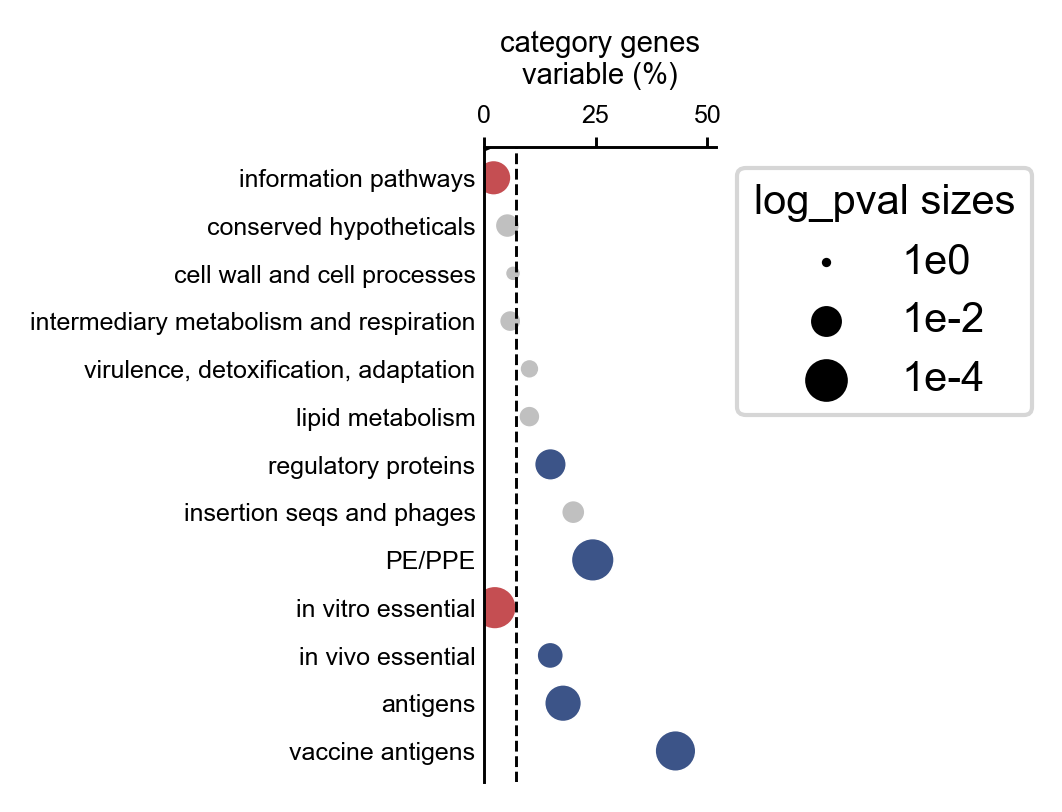

In [39]:
output_dir = 'outputs/figures'
output_name = '3A_exp_diverse_enrichment.pdf'

fig, ax = plt.subplots(1, 1, figsize=(1, 2.75))

category_enrichment_plt = category_enrichment.reset_index()
category_enrichment_plt.loc[:, 'direction'] = 'none'
category_enrichment_plt.loc[
    np.all([
        category_enrichment_plt.p_value < 0.05,
        category_enrichment_plt.category_varied_rate < category_enrichment_plt.total_varied_rate], axis=0), 'direction'] = 'lower'
category_enrichment_plt.loc[
    np.all([
        category_enrichment_plt.p_value < 0.05,
        category_enrichment_plt.category_varied_rate > category_enrichment_plt.total_varied_rate], axis=0), 'direction'] = 'higher'
category_enrichment_plt.loc[
    :, 'category_varied_rate'] = category_enrichment_plt.loc[:, 'category_varied_rate'] * 100

sns.scatterplot(
    category_enrichment_plt,
    ax=ax,
    x="category_varied_rate",
    y="index",
    hue='direction',
    size='log_pval',
    sizes=(5, 105),
    marker='o',
    size_norm=(0, 4),
    palette={'higher':'#3c5488', 'none':'#c0c0c0', 'lower':'#c54e52'},
    legend=False)
ax.axvline(
    varied_genes.sum() / considered_genes.sum() * 100,
    0, 1, color='k', lw=0.7, linestyle='--')

# manually create the legend
handles, labels = ax.get_legend_handles_labels()
size_legend = [
    plt.scatter([-1], [-1], marker='o', lw=0, color='k', s=s)
    for s in [5, 55, 105]]
labels_size = ['1e0', '1e-2', '1e-4']
legend2 = ax.legend(
    size_legend, labels_size,
    title='log_pval sizes', loc='upper left', bbox_to_anchor=(1, 1))

ax.set_xlim(0, 52)
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + 1)
ax.tick_params(axis='y', length=0)
sns.despine(bottom=True, top=False)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xlabel('category genes\nvariable (%)', labelpad=5)
ax.set_ylabel('')
ax.set_xticks([0, 25, 50])

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

# Set expression threshold

In [8]:
exp_data_path = 'rnaseq/normalized_isolate_expression.csv'
exp_df = pd.read_csv(
    exp_data_path,
    header=[0, 1, 2], index_col=0)

# get mean expression and repliate std
gene_mean_exp = exp_df.T.groupby('strain').mean().mean(0)
gene_mean_std = exp_df.T.groupby('strain').std().mean(0)
plot_df = pd.DataFrame(
    data=np.asarray([
        gene_mean_exp.values,
        gene_mean_std.values]).T,
    columns=['expression', 'standard_deviation'])

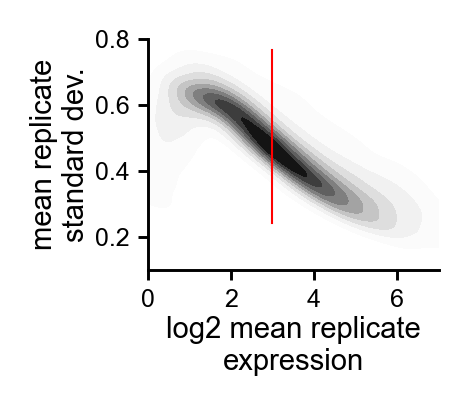

In [10]:
output_dir = 'outputs/figures'
output_name = 'S2C_set_expression_threshold.pdf'


# prepare plot
fig, ax = plt.subplots(figsize=(1.25, 1))

sns.kdeplot(
    ax=ax,
    data=plot_df,
    x='expression',
    y='standard_deviation',
    fill=True, thresh=0.05, levels=10, cmap="Greys")

ax.set_ylabel('mean replicate\nstandard dev.')
ax.set_xlabel('log2 mean replicate\nexpression')
ax.set_ylim(0.1, 0.8)
ax.set_xlim(0, 7)
ax.axvline(3, 0.2, 0.95, lw=0.5, c='r')
ax.set_xticks([0, 2, 4, 6])
sns.despine()

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)